In [ ]:
try:
    import bayes_nanospace2025
    print("Already installed")
except ImportError:
    %pip install "bayes_nanospace2025 @ git+https://github.com/Mads-PeterVC/nanospace2025.git" # Install from GitHub. 

Already installed


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

from scipy.linalg import cho_solve, cho_factor
from bayes_nanospace2025 import plot_gp_prediction

## Gaussian Processes

In this notebook we will explore Gaussian Processes; 

The notebook 4 main sections: 

1. The Gaussian process prior
2. The Gaussian process Posterior
3. Wrapping things into a versatile GP class.
4. Using GP model and choosing hyperparameters



### Gaussian Process Prior

We will start by seeing how to draw samples from a GP prior, where 

$$
y \sim \mathcal{N}(0, K(X, X))
$$

So we will need to decide on a domain for $X$ and implement a kernel function $K$.
We will start using the radial basis function (RBF) kernel, 

$$
K(x, x^*) = \exp{\left(-\frac{|x-x^*|^2}{2\lambda^2}\right)}
$$
With $|x|$ being the euclidean distance of $x$. 

In [2]:
def RBF(x1, x2, length_scale=1.0):
    """
    Radial Basis Function (RBF) kernel.
    """
    dists = cdist(
        x1, x2, "sqeuclidean"
    )  # This computes the squared Euclidean distance between all pairs of points in x1 and x2.
    K = np.exp(-dists / (2 * length_scale**2))  # Your code here.
    return K

Now that we have a kernel we can calculate the covariancee between some set of points $X$. 

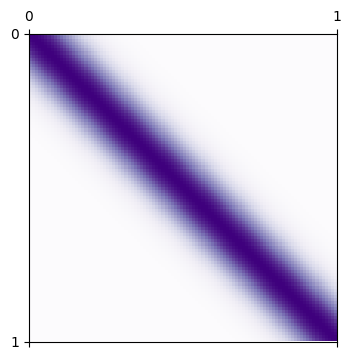

In [3]:
X = np.linspace(0, 1, 100).reshape(-1, 1)  # Create a grid of points
K = RBF(X, X, length_scale=0.1)  # Calculate the covariance

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.matshow(K, origin="upper", extent=[0, 1, 1, 0], cmap="Purples")

Now we're ready to sample some functions to do so we will

- Define a set of points $X$. 
- Calculate the covariance between those points using our kernel function. 
- Decide on a prior mean, which can just be $\mu(X) = 0$.
- Sample from a multivariate normal distribution with the mean and covariance we've defined.

The last step is handled by the `np.random.multivariate_normal` function which can be called like so: `np.random.multivariate_normal(mean, covariance, num_samples)`.

(0.0, 1.0)

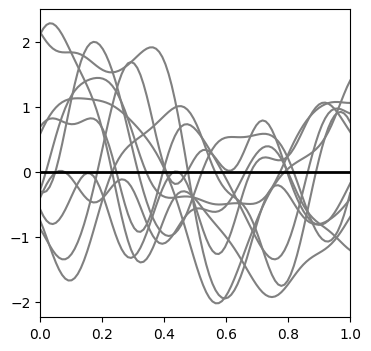

In [4]:
# Define set of points
X = np.linspace(0, 1, 100).reshape(-1, 1)  # Your code here.

# Calculate the covariance between those points using our kernel function
K = RBF(X, X, length_scale=0.1)  # Your code here.

# Define a prior mean
mean = np.zeros(X.shape[0])  # Mean function, zero everywhere

# Sample from a multivariate normal distribution with the mean and covariance we've defined
n_samples = 10
sample = np.random.multivariate_normal(mean, K, n_samples)  # Your code here.

fig, ax = plt.subplots(figsize=(4, 4))
l1 = ax.plot(X, sample.T, color="gray")
ax.plot(X, mean, color="black", lw=2, label="Mean")
ax.set_xlim(X.min(), X.max())

Thats it - these are samples from the Gaussian Process prior! Now let's try changing the kernel hyperparameters and see how that influences the sampled functions.

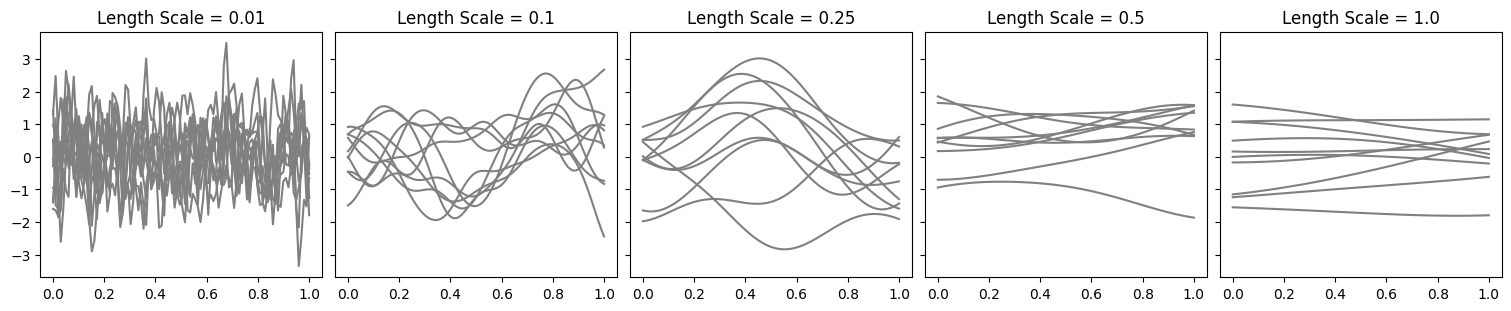

In [5]:
length_scales = [0.01, 0.1, 0.25, 0.5, 1.0]  # Different length scales to explore
X = np.linspace(0, 1, 100).reshape(-1, 1)  # Create a grid of points
mean = np.zeros(X.shape[0])  # Mean function, zero everywhere
n_samples = 10  # Number of samples to draw

fig, axes = plt.subplots(1, 5, figsize=(5 * 3, 3), sharey=True, layout="constrained")
for ax, length_scale in zip(axes, length_scales):
    samples = np.random.multivariate_normal(mean, RBF(X, X, length_scale), n_samples)
    ax.plot(X, samples.T, color="gray")
    ax.set_title(f"Length Scale = {length_scale}")

<div class="alert alert-block alert-success"><b>Takeaway:</b> The types of functions we get are clearly controlled by the kernel and it's hyperparameters. </div>

There are many choices of kernels, such as dot product kernel
$$
K(x, x^*) = (x \cdot x^*)
$$

Periodic kernel
$$
K(x, x^*) = \exp{\left( -\frac{2}{\lambda^2}\sin^2\left( \frac{\pi |x-x^*|}{p} \right) \right)}
$$

In the cell below finish implementing the periodic kernel.

In [6]:
def dot(x1, x2):
    """
    Dot product between two vectors.
    """
    return x1 @ x2.T  # This transpose is to make numpy broadcast the operation correctly.


def periodic(x1, x2, length_scale=1.0, period=1.0):
    """
    Periodic kernel.
    """
    dists = cdist(x1, x2, "euclidean")  # This computes the Euclidean distance between all pairs of points in x1 and x2.
    K = np.exp(-2 * (np.sin(np.pi * dists / period) ** 2) / (length_scale**2))  # Your code here.
    return K

A nice property of kernel functions is that they can be used as building blocks of more complex kernels just by adding and multiplying them together - kernels are **composable**.

For example, we can create a polynomial kernel as the product of two dot product kernels. 

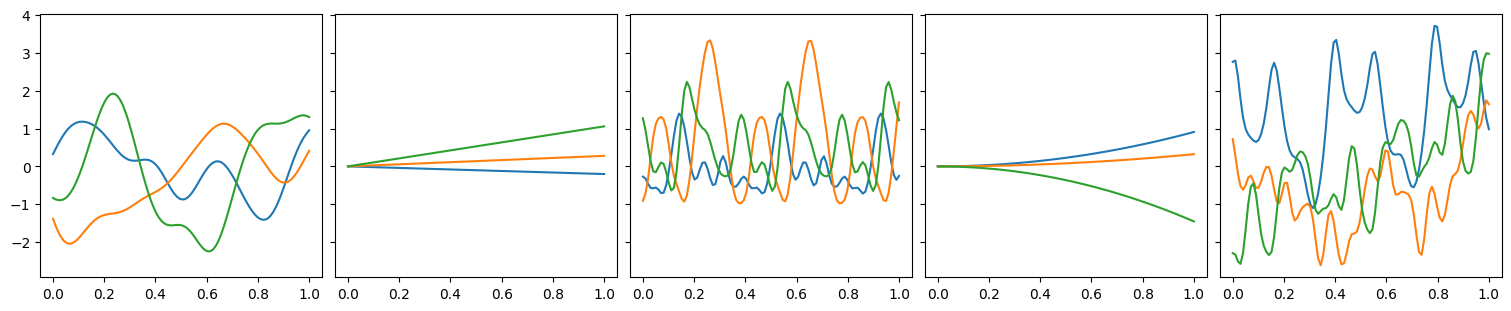

In [7]:
kernels = [
    lambda x1, x2: RBF(x1, x2, length_scale=0.1),
    dot,
    lambda x1, x2: periodic(x1, x2, length_scale=0.5, period=np.pi / 8),
]

# Try to make a quadratic kernel as the product of two dot product kernels
quadratic_kernel = lambda x1, x2: dot(x1, x2) * dot(x1, x2)  # Your code here.
kernels.append(quadratic_kernel)

# Can also make a more complex kernel by adding two kernels together
complex_kernel = lambda x1, x2: RBF(x1, x2, length_scale=0.1) + periodic(x1, x2, length_scale=0.5, period=np.pi / 8)
kernels.append(complex_kernel)


length_scales = [0.01, 0.1, 0.25, 0.5, 1.0]  # Different length scales to explore
X = np.linspace(0, 1, 100).reshape(-1, 1)  # Create a grid of points
mean = np.zeros(X.shape[0])  # Mean function, zero everywhere
n_samples = 3  # Number of samples to draw

ncols = len(kernels)

fig, axes = plt.subplots(1, ncols, figsize=(ncols * 3, 3), sharey=True, layout="constrained")
for ax, kernel in zip(axes, kernels):
    covariance = kernel(X, X)
    samples = np.random.multivariate_normal(mean, covariance, n_samples)
    ax.plot(X, samples.T)

#### Gaussian Process Prior for functions of multiple variables.

So far we've looked only at functions of a single variable, but there's really nothing special about functions of multiple variables - we just need our kernel to describe the covariance 
between sets of multiple variables. 

We've had that our "index set" $X$ is something like this 

$$
X = [x_1, x_2, x_3, ..., x_N]
$$

For more dimensions we just need to redefine our set as 

$$
X = [(x_1, y_1), (x_2, y_2), (x_3, y_3), ..., (x_N, y_N)]
$$

The cell below defines a 2D index set and calculates the RBF kernel.

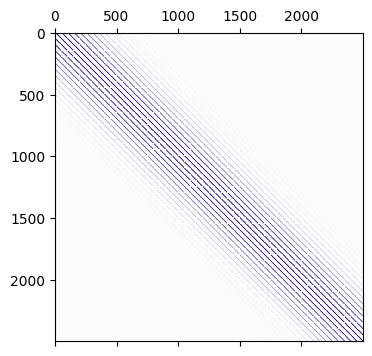

In [8]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
x_mesh, y_mesh = np.meshgrid(x, y)
X = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T


K = RBF(X, X, length_scale=0.1)  # Calculate the covariance
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.matshow(K, origin="upper", cmap="Purples")

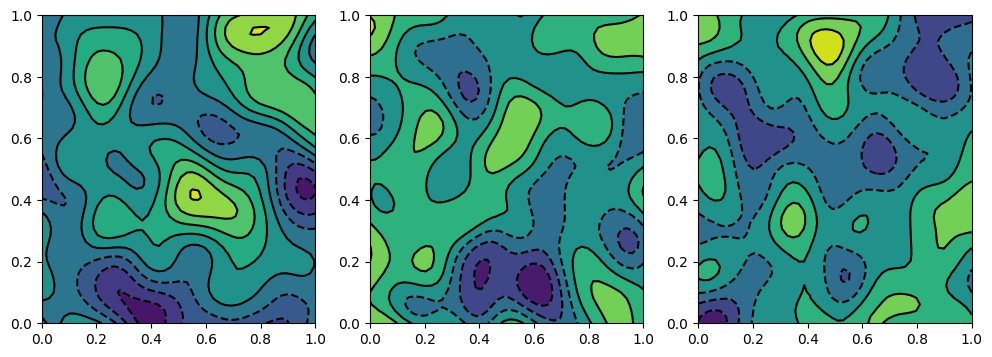

In [9]:
mean = np.zeros(X.shape[0])  # Mean function, zero everywhere
n_samples = 3  # Number of samples to draw
samples = np.random.multivariate_normal(mean, K, n_samples)  # Your code here.

fig, axes = plt.subplots(1, 3, figsize=(3 * 4, 4))

for ax, sample in zip(axes, samples):
    ax.contour(x_mesh, y_mesh, sample.reshape(x_mesh.shape), colors="black")
    ax.contourf(x_mesh, y_mesh, sample.reshape(x_mesh.shape), cmap="viridis")

<div class="alert alert-block alert-success"> <b>Takeaway:</b> GP's generalize naturally to multidimensional functions with everything handled by the kernel. </div>

### Gaussian Process Posterior

In order to use the GP for regression we would like to not just draw random functions, so we condition the GP on the observations. 
Our observations are pairs of coordinates and function values $(X, \mathbf{y})$.

This leads to following equations for the posterior mean and posterior covariance
$$
\mu(X^*) = K(X^*, X)[K(X, X)+\sigma_n^2I]^{-1}\mathbf{y}
$$ 

$$
\Sigma(X^*, X^*) = K(X^*, X^*) - K(X^*, X)[K(X, X) + \sigma^2_n I]^{-1}K(X, X^*)
$$

Where $X^*$ are where we want to query the GP and $\sigma_n^2$ is our assumed noise on the observations.

Both the posterior mean and covariance involve inverting the covariance matrix of the observations

$$
[K(X, X) + \sigma^2_n I]^{-1}
$$

Some care needs to be taken to do this in a stable and accurate way. 

---

Typically the most numerically stable and efficient way of doing so for the types of matrices encountered with GP's is Cholesky decomposition. 
With Cholesky decomposition a matrix $A$ is decomposed like so 

$$
A = LL^*
$$

The matrix $L$ can then be used to efficiently solve for the inverse of $A$ and for computing the determinant of $A$. The core routines of this 
are implemented in SciPy

- `scipy.linalg.cho_factor`: Performs the factorization to get the $L$-matrix.
- `cho_solve`: Solves the linear system of $A x = B$ given the $L$-matrix of $A$. We set $B = I$ to find the inverse.

---

In the cell below we will start by computing the posterior mean.


In [10]:
# Define some observations
X = np.array([0.3, 0.5, 0.7]).reshape(-1, 1)
y = np.array([-0.5, 0.5, 0]).reshape(-1, 1)

# Define the noise level
noise = 0.001

In [11]:
# Calculate the covariance matrix for the observations
K_obs = RBF(X, X, length_scale=0.1)  # Covariance matrix
K_obs += noise * np.eye(len(X))  # Add noise to the diagonal to include observation noise.

# Use Cholesky decomposition to compute the inverse of the covariance matrix
L, _ = cho_factor(K_obs, True)  # Cholesky factorization
K_obs_inv = cho_solve((L, True), np.eye(len(X)))  # Inverse of the covariance matrix

# Evaluate the posterior mean
X_query = np.linspace(0, 1, 100).reshape(-1, 1)  # Points where we want to make predictions
K_query = RBF(X_query, X, length_scale=0.1)  # Covariance between query points and observations

print(f"{K_query.shape = } - Should be (100, 3)")
print(f"{K_obs_inv.shape = } - Should be (3, 3)")
print(f"{y.shape = }         - Should be (3, 1)")

mu_posterior = K_query @ K_obs_inv @ y  # Your code here.

K_query.shape = (100, 3) - Should be (100, 3)
K_obs_inv.shape = (3, 3) - Should be (3, 3)
y.shape = (3, 1)         - Should be (3, 1)


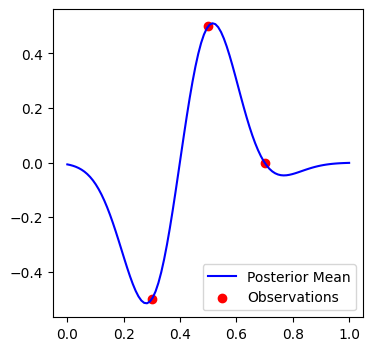

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(X_query, mu_posterior, color="blue", label="Posterior Mean")
ax.scatter(X, y, color="red", label="Observations")
ax.legend()

If you've done it right you should see that the posterior mean closely matches the observations.

If that's the case, we can move onto the posterior covariance, we will also calculate posterior standard deviation 

$$
\sigma(X^*_i) = \Sigma(X^*_i, X^*_i)
$$

$$
\mathrm{std}(X^*_i) = \sqrt{\sigma(X^*_i)}
$$

Or in other words the standard deviations are the square root of the diagonal elements. Again, the posterior covariance is given by

$$
\Sigma(X^*, X^*) = K(X^*, X^*) - K(X^*, X)[K(X, X) + \sigma^2_n I]^{-1}K(X, X^*)
$$

In [13]:
K_qq = RBF(X_query, X_query, length_scale=0.1)  # Covariance matrix for the query points.
cov_posterior = K_qq - K_query @ K_obs_inv @ K_query.T  # Your code here.

var_posterior = np.diag(cov_posterior)  # Variance of the posterior distribution
std_posterior = np.sqrt(var_posterior)  # Standard deviation of the posterior

Now that we have everything lets just check the shapes and confirm that what we have is 

- The posterior mean $\mu_\mathrm{posterior}$ as an array with as many elements $N_\mathrm{query}$ as were in $X_\mathrm{query}$. 
- The posterior covariance as a matrix of shape $N_\mathrm{query} \times N_\mathrm{query}$.
- Posterior variance and standard deviation each with $N_\mathrm{query}$ elements. 

In [14]:
print(f"{mu_posterior.shape = } - Should be (100, 1)")
print(f"{cov_posterior.shape = } - Should be (100, 100)")
print(f"{var_posterior.shape = } - Should be (100,)")
print(f"{std_posterior.shape = } - Should be (100,)")

mu_posterior.shape = (100, 1) - Should be (100, 1)
cov_posterior.shape = (100, 100) - Should be (100, 100)
var_posterior.shape = (100,) - Should be (100,)
std_posterior.shape = (100,) - Should be (100,)


In [15]:
# With the posterior mean and covariance we can draw samples from the posterior distribution
n_samples = 10  # Number of samples to draw
samples = np.random.multivariate_normal(mu_posterior.flatten(), cov_posterior, n_samples, check_valid="ignore")

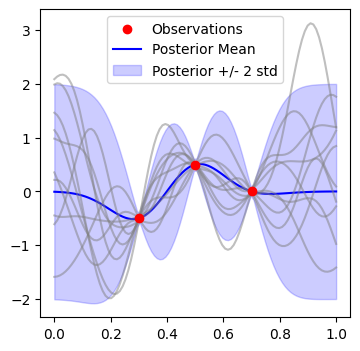

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(X, y, color="red", label="Observations", zorder=5)
ax.plot(X_query, mu_posterior, color="blue", label="Posterior Mean")
ax.fill_between(
    X_query.flatten(),
    mu_posterior.flatten() + 2 * std_posterior.flatten(),
    mu_posterior.flatten() - 2 * std_posterior.flatten(),
    color="blue",
    alpha=0.2,
    label="Posterior +/- 2 std",
)

l = ax.plot(X_query, samples.T, color="gray", alpha=0.5)
ax.legend()

<div class="alert alert-block alert-success"> <b>Takeaway:</b> You've now implemented the predictive equations of a GP! </div>

#### Log marginal likelihood.

The last thing we want to be able to calculate is the **log marginal likelihood** a measure of how well the Gaussian Process with given hyperparameters explains the observed data, balancing data fit and model complexity.

$$
\begin{equation}
\begin{aligned}
\mathrm{LML} = \log p(y | X ) =& -\frac{1}{2} \mathbf{y}^T(K(X, X) + \sigma^2_n I)^{-1}\mathbf{y} \\
& -\frac{1}{2} \log |K(X, X) + \sigma^2_n I| \\
& - \frac{n}{2} \log 2\pi
\end{aligned}
\end{equation}
$$

Where $|...|$ in the second term is the determinant of the matrix. The three terms can be interpreted as 

1. Data fit - how well do the function in the distribution fit the data?
2. Model complexity - how complex is the model? 
3. A normalization constant. 

The first and the second term thus strike some balance that helps avoid overfitting. 

The first term includes the matrix inversion that've already seen how to do with Cholesky decomposition. 
The second term requires calculating the determinant of the same matrix, to ensure numerical stability a little bit of thought 
is required here. 

----

However, it turns out that the determinant can be calculated from the Cholesky factorization $L$. 
Again for a matrix $A$ the Cholesky decompositions is defined through 
$$
A = LL^*
$$
The determinant of $A$ can be stated as 
$$
|A| = \prod_i^n L_{ii}^2
$$
And therefore the log-determinant is 
$$
\log |A| = 2 \sum_i^n \log L_{ii}
$$
We thus get the log-determinant as the sum of the log of the diagonal elements of $L$ - which offers better numerical accuracy and stability compared to 
other methods in my experience. 

----

The LML is typically used to choose hyperparameters, so we will write a function that computes the LML given some data and the GP hyperparameters.

In [17]:
def lml(X, y, length_scale=1.0, noise=0.001, amplitude=1.0):
    """
    Log Marginal Likelihood (LML) for Gaussian Process Regression.
    """
    n = X.shape[0]

    K = amplitude * RBF(X, X, length_scale)  # Covariance matrix
    K += noise * np.eye(n)  # Add noise to the diagonal

    L, _ = cho_factor(K, True)  # Cholesky factorization
    K_inv = cho_solve((L, True), np.eye(n))  # Solve for alpha

    lml_value = 0
    lml_value += -0.5 * y.T @ K_inv @ y  # Your code here.
    lml_value += -np.sum(np.log(np.diag(L)))  # Your code here.
    lml_value += -n / 2 * np.log(2 * np.pi)  # Your code here.

    return lml_value.flatten()[0]  # Return as a scalar

In [18]:
X = np.array([0.3, 0.5, 0.7]).reshape(-1, 1)
y = np.array([-0.5, 0.5, 0]).reshape(-1, 1)

lml(X, y, length_scale=0.1, noise=0.001)  # Should give -3.0315

-3.031589571234687

### Optional: Creating a GPR Model.

<div class="alert alert-block alert-info"> <b>Note:</b> You can skip this part and use my implementation instead. </div>

So far we've seen all the elements required to construct and utilize a Gaussian process
- The kernel.
- The prior mean and covariance.
- The posterior mean and covariance.
- Sampling from the prior or the posterior.
- Calculating the log marginal likelihood.

However, it is not particularly structured, reusable or versatile. It's typically quite useful to wrap 
all these elements in a "Model"-object, similar to a `torch.Module`, such that when using it we don't need to think 
about carrying the right matrices around. 

This is really a software design thing and there are a number of ways to do so each with benefits for certain use cases. 

#### Kernel class

I've implemented a simple `Kernel`-base class that's imported below. 

It really only handles two things; 
- Allows composition of kernels through addition and multiplication.
- Defines a consistent API. 

To implement a kernel with this, two methods have to be defined

- `__init__`: Set the kernel hyperparameters. 
- `__call__`: Compute the kernel given two arrays.

In the cell below implement the RBF kernel by completing the `__call__` method.

In [19]:
from bayes_nanospace2025.tutorial.kernels import Kernel


class RadialBasis(Kernel):
    """
    Radial Basis Function (RBF) kernel.
    """

    def __init__(self, length_scale=1.0):
        super().__init__()
        self.length_scale = length_scale

    def __call__(self, x1, x2=None):
        if x2 is None:
            x2 = x1
        dists = cdist(x1, x2, "sqeuclidean")  # Your code here.
        return np.exp(-dists / (2 * self.length_scale**2))  # Your code here.

With composable kernels we can include noise as a kernel.

There are some implementation subtleties with this, we need the implementation to 
behave like so: 

- $K(X, X)$: Noise added to the diagonal.
- $K(X, Y)$: No noise added. 

We accomplish this by defining that $K(X) = K(X, X)$ - so noise is only added if only one 
input set is provided. 

In [20]:
class Noise(Kernel):
    """
    Noise kernel.
    """

    def __init__(self, noise_level=1e-3):
        super().__init__()
        self.noise_level = noise_level

    def __call__(self, x1, x2=None):
        if x2 is not None:
            return np.zeros((x1.shape[0], x2.shape[0]))
        else:
            return self.noise_level * np.eye(x1.shape[0])

We can check that this behaves as expected;

In [21]:
kernel = RadialBasis(length_scale=0.1) + Noise(noise_level=0.001)

X = np.linspace(0, 1, 10).reshape(-1, 1)  # Create a grid of points

Kx = kernel(X)  # Covariance matrix for the grid points.
Kxy = kernel(X, X)  # Covariance matrix for the grid points.

print(f"{Kx.max() = } - Should be 1.001")
print(f"{Kxy.max() = } - Should be 1.000")

Kx.max() = 1.001 - Should be 1.001
Kxy.max() = 1.0 - Should be 1.000


Finally we will add a `Constant` kernel that just acts as an amplitude.

$$
K(X, X) = \sigma_f
$$

In [22]:
class Constant(Kernel):
    """
    Constant kernel.
    """

    def __init__(self, amplitude=1.0):
        super().__init__()
        self.amplitude = amplitude

    def __call__(self, x1, x2=None):
        return self.amplitude 

Again we can do a little bit of sanity checking

In [23]:
X = np.linspace(0, 1, 10).reshape(-1, 1)  # Create a grid of points
kernel = Constant(amplitude=2.0) * RadialBasis(length_scale=0.1) + Noise(noise_level=0.001)

K = kernel(X, X)
print(f"{K.max() = } - Should be 2.0")
print(f"{K.min() = } - Should be very small.")


K.max() = 2.0 - Should be 2.0
K.min() = 3.857499695927863e-22 - Should be very small.


Now we have enough kernels to continue, but if you want to implement e.g. the periodic or the dot product kernel as 
one the classes feel free to do so.

#### GP Class

Now we can implement a `GaussianProcess`-class. 

To keep things neat I've defined two dataclasses 

- `PosteriorState`: To contain all the information needed to calculate properties of the posterior. 
- `PredictionResult`: To contain predicted properties, e.g. the mean, variance and covariance at the given query points.

Additionally, this implementation a couple of minor differences compared to what we've seen before. 
Firstly, the prior mean can be set - this changes the equation for the posterior mean: 

$$
\mu(X^*) = K(X^*, X)[K(X, X)+\sigma_n^2I]^{-1}(\mathbf{y}-\mu_\mathrm{prior}(X)) + \mu_\mathrm{prior}(X^*)
$$

Which is equal to what we've used so far if $\mu_\mathrm{prior} = 0$, this can be useful to e.g. set 
the prior mean to the mean of the observed data reducing the magnitude of what the GP has to fit. 

Secondly, we have now included data noise in the kernel and we do therefore not need to explicitly add it 
when calculating 

$$
[K(X, X)+\sigma_n^2I]^{-1} \rightarrow [K(X, X)+\sigma_\mathrm{jitter}I]^{-1}
$$

However, for numerical stability a very small diagonal noise term is still added - this is called a *jitter*.

In [24]:
from dataclasses import dataclass
from typing import Callable


@dataclass
class PosteriorState:
    X_train: np.ndarray  # Training inputs
    y_train: np.ndarray  # Training outputs
    K_inv: np.ndarray  # Inverse of the covariance matrix for training inputs
    alpha: np.ndarray  # Vector for computing the posterior mean
    cholesky_factor: np.ndarray


@dataclass
class PredictionResult:
    X_query: np.ndarray  # Query points where predictions are made
    mean: np.ndarray  # Posterior mean at query points
    variance: np.ndarray  # Posterior variance at query points
    covariance: np.ndarray  # Posterior covariance matrix at query points


class GaussianProcess:
    def __init__(self, kernel: Kernel, prior_mean: Callable | float | None = None, jitter: float = 1e-9):
        self.kernel = kernel
        self.jitter = jitter
        self.prior_mean = prior_mean if prior_mean is not None else 0
        self.state = None  # This will hold the posterior state after conditioning on observed data

    def condition(self, X_obs, y_obs) -> None:
        """
        Condition the Gaussian Process on observed data.
        """
        K_obs = self.kernel(X_obs)  # Covariance matrix for the observations
        K_obs += self.jitter * np.eye(len(X_obs))  # Add jitter to the diagonal to ensure numerical stability

        # Use Cholesky decomposition to compute the inverse of the covariance matrix
        L, _ = cho_factor(K_obs, lower=True)  # Cholesky factorization
        K_obs_inv = cho_solve((L, True), np.eye(len(X_obs)))  # Inverse of the covariance matrix

        # If prior_mean is callable, evaluate it at X_obs; otherwise, use a constant prior mean
        prior_mean = self.prior_mean(X_obs) if callable(self.prior_mean) else np.full((len(X_obs), 1), self.prior_mean)
        y = y_obs - prior_mean  # Adjust observed outputs by subtracting the prior mean

        # Compute alpha for efficient posterior mean computation
        alpha = K_obs_inv @ y

        self.state = PosteriorState(X_train=X_obs, y_train=y, K_inv=K_obs_inv, alpha=alpha, cholesky_factor=L)

    def predict(self, X_query: np.ndarray) -> PredictionResult:
        """
        Predict the mean and variance at new query points.
        """
        state = self.state

        prior_mean = (
            self.prior_mean(X_query) if callable(self.prior_mean) else np.full((len(X_query), 1), self.prior_mean)
        )

        if state is None:
            K_qq = self.kernel(X_query)  # Prior covariance for the query points.
            return PredictionResult(
                X_query=X_query,
                mean=prior_mean,
                variance=np.diag(K_qq),
                covariance=K_qq,
            )

        # Predicting the posterior mean
        K_query = self.kernel(X_query, state.X_train) # Your code here. 

        # K_query: (n_query, n_train) - alpha: (n_train, 1) - prior_mean: (n_query, 1)
        mu_posterior = K_query @ state.alpha + prior_mean  # Your code here.

        # Predicting the posterior covariance
        K_qq = self.kernel(X_query)  # Covariance matrix for the query points (n_query, n_query).
        cov_posterior = K_qq - K_query @ state.K_inv @ K_query.T  # Your code here. (n_query, n_query)

        # Compute the posterior variance as the diagonal of the covariance matrix
        var_posterior = np.diag(cov_posterior).copy() # (n_query, )
        var_posterior[var_posterior < 0] = 0  # Ensure non-negative variance

        return PredictionResult(X_query=X_query, mean=mu_posterior, variance=var_posterior, covariance=cov_posterior)

    def sample(self, X_query: np.ndarray, n_samples: int = 1, cov_jitter: float = 1e-6) -> np.ndarray:
        """
        Sample from the posterior distribution at query points.
        """
        prediction = self.predict(X_query)
        samples = np.random.multivariate_normal(
            prediction.mean.flatten(),
            prediction.covariance + np.eye(prediction.covariance.shape[0]) * cov_jitter,
            n_samples,
            check_valid="ignore",
        )
        return samples

    def log_marginal_likelihood(self) -> float:
        """
        Compute the log marginal likelihood of the observed data.
        """
        y = self.state.y_train
        K_inv = self.state.K_inv
        L = self.state.cholesky_factor

        lml = -0.5 * y.T @ K_inv @ y - np.sum(np.log(np.diag(L))) - len(y) / 2 * np.log(2 * np.pi)
        return lml.flatten()[0]

Now we can try using the model

In [25]:
X_obs = np.array([0.3, 0.5, 0.7]).reshape(-1, 1)
y_obs = np.array([-0.5, 1, 0]).reshape(-1, 1)
X_query = np.linspace(0, 1, 100).reshape(-1, 1)

# Construct GP
kernel = Constant(1.0) * RadialBasis(length_scale=0.1) + Noise(noise_level=1e-6)
gp = GaussianProcess(kernel)

prior_prediction = gp.predict(X_query)  # Predict the prior mean and variance at query points

print(prior_prediction.mean.shape)  # Should be (100, 1)
print(prior_prediction.covariance.shape)  # Should be (100, 100)

gp.condition(X_obs, y_obs)  # Condition the GP with observed data

posterior_prediction = gp.predict(X_query)  # Predict the prior mean and variance at query points
print(posterior_prediction.mean.shape)  # Should be (100, 1)
print(posterior_prediction.covariance.shape)  # Should be (100, 100)

(100, 1)
(100, 100)
(100, 1)
(100, 100)


The cell below does the same thing and plots the results. 

The `plot_gp_prediction`-function is just a simple little plotting utility function, you can see its definition using a notebook magic `plot_gp_prediction??` in a code cell. 

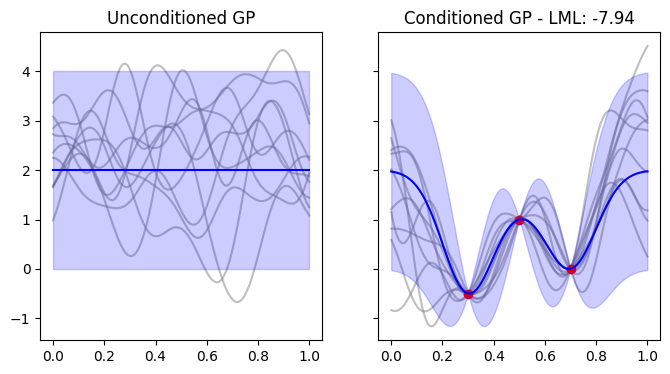

In [26]:
# Construct GP
kernel = Constant(1.0) * RadialBasis(length_scale=0.1) + Noise(noise_level=1e-6)
prior_mean = lambda x: 2* np.ones_like(x)  # Constant prior mean function - you can try changing this.
gp = GaussianProcess(kernel=kernel, prior_mean=prior_mean)

# Make some data
X_obs = np.array([0.3, 0.5, 0.7]).reshape(-1, 1)
y_obs = np.array([-0.5, 1, 0]).reshape(-1, 1)
X_query = np.linspace(0, 1, 100).reshape(-1, 1)

# Plotting 
fig, axes = plt.subplots(1, 2, figsize=(2 * 4, 4), sharey=True)
for ax, condition in zip(axes, [False, True]):
    if condition:
        gp.condition(X_obs, y_obs)  # Condition the GP with observed data
        ax.scatter(X_obs, y_obs, color="red", label="Observations")

        lml = gp.log_marginal_likelihood()
        ax.set_title("Conditioned GP - LML: {:.2f}".format(lml))
    else:
        ax.set_title("Unconditioned GP")

    # Query the GP for predictions
    prediction = gp.predict(X_query)
    plot_gp_prediction(ax, prediction)

    samples = gp.sample(X_query, n_samples=10)
    for sample in samples:
        ax.plot(X_query, sample, color="gray", alpha=0.5, zorder=-1)

### Using GP model.

<div class="alert alert-block alert-info"> <b>Note:</b> If you skipped the previous section you can import and use 
my version of the `GaussianProcess`-class by uncommenting the import block below.</div>

In [27]:
# Uncomment the following line to import the GaussianProcess class and related kernels
# Keep commented if you want to use your own version of the GaussianProcess class.
# from bayes_nanospace2025 import GaussianProcess, RadialBasis, Noise, Constant

In [28]:
def f(x):
    """
    A simple function to model.
    """
    return np.sin(2 * np.pi * x) + 0.1 * np.random.randn(*x.shape)

# Generate some training data
np.random.seed(42)  # For reproducibility
n_data = 25
X_obs = np.random.uniform(-5, 5, size=(n_data, 1))
y_obs = f(X_obs)

X_query = np.linspace(-5, 5, 1000).reshape(-1, 1)

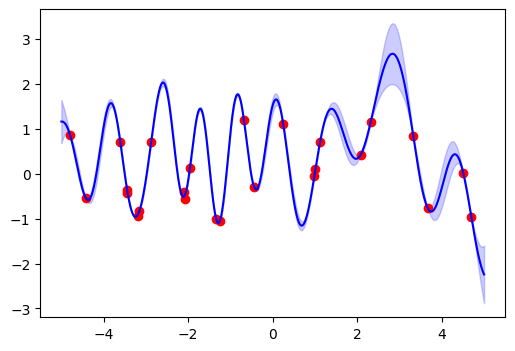

In [29]:
# Setup GP & predict
kernel = Constant(1) * RadialBasis(length_scale=0.5) + Noise(noise_level=1e-6)
gp = GaussianProcess(kernel=kernel, prior_mean=0)
gp.condition(X_obs, y_obs)
prediction = gp.predict(X_query)

# Plotting 
fig, ax = plt.subplots(figsize=(6, 4))
plot_gp_prediction(ax, prediction)
ax.scatter(X_obs, y_obs, color="red", label="Observations")

In [30]:
# Plot the lml landscape
noise_levels = np.geomspace(0.001, 0.75, 50)
length_scales = np.geomspace(0.01, 5.0, 50)
lenth_mesh, noise_mesh = np.meshgrid(length_scales, noise_levels)
lml_values = np.zeros((len(noise_levels), len(length_scales)))
for i, noise in enumerate(noise_levels):
    for j, length_scale in enumerate(length_scales):
        kernel = Constant(1) * RadialBasis(length_scale=length_scale) + Noise(noise_level=noise)
        gp = GaussianProcess(kernel=kernel, prior_mean=0)
        gp.condition(X_obs, y_obs)
        lml_values[i, j] = gp.log_marginal_likelihood()

lml_values = np.clip(lml_values, a_min=-50, a_max=None)  # Clip values for better visualization

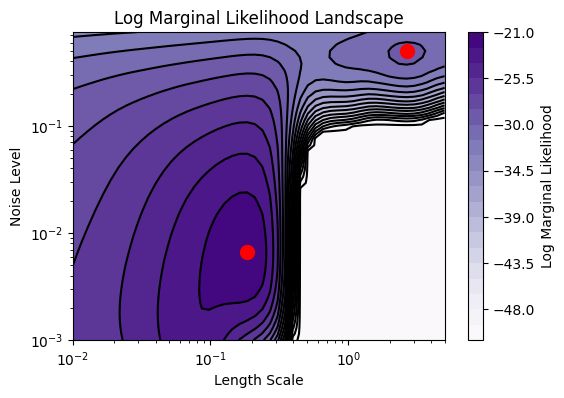

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))

# Make the contour plot
ax.contour(length_scales, noise_levels, lml_values, levels=20, colors="black", linestyles='-')
c = ax.contourf(length_scales, noise_levels, lml_values, levels=20, cmap="Purples")

# Plot the maximum log marginal likelihood
index_0 = np.unravel_index(np.argmax(lml_values), lml_values.shape)
index_1 = np.unravel_index(np.argmax(lml_values - 1000 * (length_scales < 1)), lml_values.shape)

for max_index in [index_0, index_1]:
    ax.plot(length_scales[max_index[1]], noise_levels[max_index[0]], "ro", markersize=10, label="Max LML")


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Length Scale")
ax.set_ylabel("Noise Level")
ax.set_title("Log Marginal Likelihood Landscape")
fig.colorbar(c, ax=ax, label="Log Marginal Likelihood")

We can now make a GP with the optimal hyperparameter values

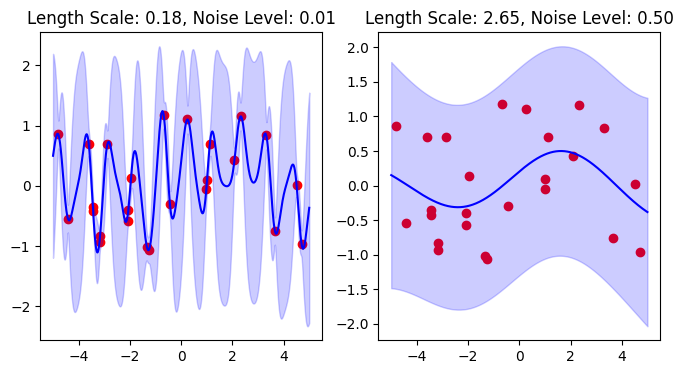

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, max_index in zip(axes, [index_0, index_1]):
    length_scale = length_scales[max_index[1]]
    noise_level = noise_levels[max_index[0]]

    kernel = Constant(1) * RadialBasis(length_scale=length_scale) + Noise(noise_level=noise_level)
    gp = GaussianProcess(kernel=kernel, prior_mean=0)
    gp.condition(X_obs, y_obs)
    prediction = gp.predict(X_query)

    ax.scatter(X_obs, y_obs, color="red", label="Observations")
    plot_gp_prediction(ax, prediction)
    ax.set_title(f"Length Scale: {length_scale:.2f}, Noise Level: {noise_level:.2f}")

<div class="alert alert-block alert-success"> <b>Takeaway:</b> The log marginal likelihood landscape proposes two hypothesis for our data; one that is quickly varying with low variance that closely fits the data and one that is slowly varying with high variance. </div>

A grid search is not particularly efficient, so normally gradient-based optimization is employed. 
The analytical gradients of the LML wrt. kernel hyperparameters can be derived but it's tedious - 
so we will stick to a gradient-free optimization procedure. 

In [54]:
def optimize_hyperparameters(initial_guess, X_obs, y_obs):
    from scipy.optimize import minimize

    def calculate_lml(length_scale, noise_level, amplitude):
        kernel = Constant(amplitude) * RadialBasis(length_scale=length_scale) + Noise(noise_level=noise_level)
        gp = GaussianProcess(kernel=kernel, prior_mean=0)
        gp.condition(X_obs, y_obs)
        return gp.log_marginal_likelihood()
    
    bounds = [(1e-6, 5.0), (1e-3, 2.0), (0.1, 10)]  # Bounds for length_scale and noise_level
    result = minimize(
        lambda x: -calculate_lml(x[0], x[1], x[2]),  # We minimize the negative log marginal likelihood
        initial_guess,
        bounds=bounds,
    )
    print(f"Optimal Length Scale: {result.x[0]:.4f}, Optimal Noise Level: {result.x[1]:.4f}, Optimal Amplitude: {result.x[2]:.4f}")
    

    return result.x  # Return the optimal hyperparameters

In [55]:
set_1 = optimize_hyperparameters([0.1, 0.1, 1.0], X_obs, y_obs) # Initial guess for length_scale, noise_level, and amplitude
set_2 = optimize_hyperparameters([2, 0.5, 1.0], X_obs, y_obs) # Another initial guess

Optimal Length Scale: 0.1360, Optimal Noise Level: 0.0063, Optimal Amplitude: 0.5896
Optimal Length Scale: 1.3332, Optimal Noise Level: 0.4854, Optimal Amplitude: 0.1000


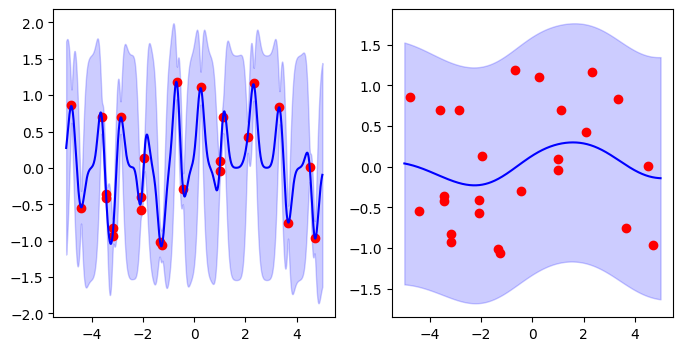

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, x in zip(axes, [set_1, set_2]):
    kernel = Constant(x[2]) * RadialBasis(length_scale=x[0]) + Noise(noise_level=x[1])
    gp = GaussianProcess(kernel=kernel, prior_mean=0)
    gp.condition(X_obs, y_obs)

    predictions = gp.predict(X_query)

    plot_gp_prediction(ax, predictions)
    ax.scatter(X_obs, y_obs, color="red", label="Observations")